In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint as pp

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from collections import Counter

In [5]:
from helper_methods import plot_confusion_matrices, plot_classification_report

# BACKGROUND

Two modeling areas are investigated:
- encoding of feature `soil_index`
- handling target class imbalance

### feature `soil_index`
Feature `soil_index` is non-ordinal, categorical with 40 values. Each value has a particular ecological meaning. Each value is associated with a climatic zone (7 possibilities) and a geologic zone (4 possibilities.) These zones provide a domain informed way to cluster the 40 values. The purpose of this work is to investigate how different techniques for handling this feature impact the performance of several models.

The techniques investigated are
- one-hot encoding (40 values)
- frequency encoding
- climatic zone clustering (7 values)
- geologic zone clustering (4 values)
- climatic + geologic zone clustering (11 combinations are present in the data)

These models are investigated using `pycaret`:
- logistic regression
- decision tree
- XGBoost
- LightGBM (uses categorical features directly)
- CatBoost (uses categorical features directly)

For LightGBM and CatBoost,the category values (original, climatic zone, etc.) are used directly; they are not one-hot encoded. For all other models, the original values and the cluster values are one-hot encoded. Default values are used for all hyper-parameters.   
   
### target class imbalance
There is a significant class imbalance. The 5 smallest classes are present at less than 7% each with a total of 15%. Each of these is over-sampled to increase its total count by a factor of 3. The `pycaret` functionality for including `imbalanced_learn` for over-sampling and cleaning is used.
   
The investigation of `soil_index` was completed first. Based on the 3 fold CV performance metrics results (discussed below), the first class imbalance investigation used frequency encoding and these models (default values for all hyper-parameters):
- decision tree
- XGBoost
- CatBoost
   
Investigation of `soil_index` also involved calculating performance metrics by class. Based on these results (discussed below), the second class imbalance investigation used geologic zone encoding because it has the fewest clusters--4 versus 7 or 11.    
   
A third class imbalance investigation used an oversampling factor of 1.5 and geologic zone encoding.   

The modeling runs are in separate notebooks. This notebook contains plots of the results.

# CONCLUSIONS
### feature `soil_index`
##### model metrics (3 fold CV results)
For each model, the accuracy, weighted metrics (precision, recall, f1), and macro metrics (precision, recall, f1) are slightly better for one hot and frequency encoding.   

Decision tree has significantly better accuracy that the other models. It's other metrics, except for precision macro, are also better.

Logistic regression performs significantly worse than all other models.

The 3 remaining models generally have similar performance with the ordering of best to worse: CatBoost, XGBoost, LightGBM. No hyper-parameter tuning was done.
   
##### model metrics (predict entire training set)
Decision tree is overfit for the 3 cluster encoding techniques as its metrics are very close to 1. However, the metrics from the CV calculation are about 0.9.

For one hot encoding: metrics calculated using the entire training set are slightly worse than the CV calculation.

For frequency encoding: I do not have an explanation for the significant difference between all training data and the CV calculation.

For 3 cluster encoding techniques:
- little difference between all training data and CV calculation for weighted metrics
- all training data is slightly better for macro metrics
- except for decision tree as stated above 
   
##### metrics by class (predict entire training set)
Precision and recall were calculated for each class. In general, the 3 cluster encoding techniques perform better for each model. (Except for logistic regression which has significantly poorer performance than all other models.) There is little difference in performance among those 3 techniques.   
   
##### training time
For models that do not directly use categorical features, one-hot takes significantly longer to train than the other encoding techniques. The other techniques take approximately the same amount of time with one-hot taking 30-40% more than this amount.   
   
The runs were done using a free GPU machine in Paperspace Gradient.
   
### target class imbalance with factor = 3
##### model metrics for frequency encoding
- little difference between with and without `imblearn`
- same strange behavior between all training data and CV calculation

##### model metrics for geologic cluster encoding
- little difference between with and without `imblearn`
- decision tree again is overfit   
   
##### metrics by class for frequency encoding
- no significant improvement in performance   

##### metrics by class for geologic cluster encoding
- with `imblearn`, precision is slightly lower and recall slightly higher for 5 smallest classes
- decision tree again is overfit
   
### target class imbalance with factor = 1.5
##### metrics by class for geologic cluster encoding
- with `imblearn`, there are slight differences in performance for 5 smallest classes
- differences are smaller than factor=3
- unlike factor=3, there is no clear pattern in differences

# preamble

In [6]:
#read_csv_files = True
read_csv_files = False

# read csv files

In [7]:
if read_csv_files:
    cols_csv = ['Name', 'Accuracy', 'F1', 'F1 Macro', 'Prec', 'Precision Macro', 'Recall Macro', 'Recall Weighted', 'TT']
    cols_df = ['Name', 'Accuracy', 'Precision Macro', 'Recall Macro', 'F1 Macro', 'Prec', 'Recall Weighted', 'F1', 'TT' ]

    df_pycaret_results = pd.DataFrame()

    #encoding_list = ['one_hot', 'frequency', 'climatic_clusters', 'geologic_clusters', 'both_clusters']
    encoding_list = ['one_hot', 'frequency', 'climatic_clusters', 'geologic_clusters', 'both_clusters', 'freq_with_imblearn']

    for item in encoding_list:
        file_name = 'pycaret_results_ps/' + item + '.csv'

        df_temp = pd.read_csv(file_name, usecols=cols_csv)[cols_df]
        df_temp.dropna(inplace=True)
        #df_temp

        df_temp = df_temp.rename(columns=
                                 {'Prec':'Precision Weighted',
                                  'F1':'F1 Weighted',
                                  'TT':'Train Time, sec'
                                 })
        df_temp['Soil Encoding'] = item

        if (item.find('imblearn') > 0):
            df_temp['imblearn'] = 'yes'
        else:
            df_temp['imblearn'] = 'no'

        #df_temp

        df_pycaret_results = df_pycaret_results.append(df_temp)

    df_pycaret_results.reset_index(drop=True, inplace=True)
    df_pycaret_results

# read pickle files

In [8]:
pycaret_results_dir = 'pycaret_df_results/'

In [9]:
cover_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']
get_target_name_from_integer = lambda i : cover_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

In [10]:
df_pycaret_results  = pd.DataFrame()
df_results_by_class = pd.DataFrame()
df_results_summary  = pd.DataFrame()

### target counts

In [11]:
df_target_counts = pd.read_pickle(pycaret_results_dir + 'df_target_counts.pkl')
df_target_counts

,cover_type,count,fraction,target_name
1,1,211840,0.364605,spruce_fir
0,2,283301,0.487599,lodgepole_pine
2,3,35754,0.061537,ponderosa_pine
6,4,2747,0.004728,cottonwood_willow
5,5,9493,0.016339,aspen
4,6,17367,0.029891,douglas_fir
3,7,20510,0.035300,krummholz


In [12]:
get_target_fraction_from_name = lambda name : df_target_counts[df_target_counts['target_name']==name]['fraction'].values[0]
get_target_fraction_from_name('aspen')

0.016338733107061472

### read results files: soil encoding

In [13]:
df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'soil_df_pycaret_model_metrics_p4.pkl')
df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'soil_df_report_by_class_p4.pkl')
df_temp_results_summary  = pd.read_pickle(pycaret_results_dir + 'soil_df_report_summary_p4.pkl')

df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                 {'Prec.':'Precision Weighted',
                                  'F1':'F1 Weighted',
                                  'TT (Sec)':'Train Time, sec'
                                 })
df_temp_pycaret_results['imblearn'] = 'no'
df_temp_pycaret_results

df_temp_results_summary = df_temp_results_summary.rename(columns=
                                 {'model':'Model',
                                  'accuracy':'Accuracy',
                                  'macro_precision':'Precision Macro',
                                  'macro_recall':'Recall Macro',
                                  'macro_f1-score':'F1 Macro',
                                  'weight_precision':'Precision Weighted',
                                  'weight_recall':'Recall Weighted',
                                  'weight_f1-score':'F1 Weighted'
                                 })
df_temp_results_summary['imblearn'] = 'no'
df_temp_results_summary

df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
df_temp_results_by_class['imblearn'] = 'no'
#df_temp_results_by_class
df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
#df_temp_results_by_class
df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
df_temp_results_by_class

df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)
df_results_summary  = df_results_summary.append(df_temp_results_summary, ignore_index=True)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot,no
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot,no
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot,no
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot,no
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot,no
5,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600,frequency,no
6,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167,frequency,no
7,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633,frequency,no
8,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167,frequency,no
9,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333,frequency,no


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot,no
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot,no
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot,no
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot,no
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot,no
5,Decision Tree Classifier,train,0.591847,0.440894,0.469238,0.428013,0.632840,0.591847,0.599689,frequency,no
6,CatBoost Classifier,train,0.720900,0.754692,0.625797,0.615435,0.755243,0.720900,0.714539,frequency,no
7,Extreme Gradient Boosting,train,0.753504,0.783948,0.616751,0.625485,0.762202,0.753504,0.746039,frequency,no
8,Light Gradient Boosting Machine,train,0.728550,0.671213,0.667900,0.644337,0.747223,0.728550,0.728038,frequency,no
9,Logistic Regression,train,0.696060,0.518736,0.468438,0.459588,0.685865,0.696060,0.683425,frequency,no


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen
...,...,...,...,...,...,...,...,...,...
170,Logistic Regression,train,0.659538,0.824324,0.732781,25103,both clusters,no,ponderosa_pine
171,Logistic Regression,train,0.706140,0.251301,0.370683,1922,both clusters,no,cottonwood_willow
172,Logistic Regression,train,0.000000,0.000000,0.000000,6665,both clusters,no,aspen
173,Logistic Regression,train,0.466064,0.182883,0.262687,12128,both clusters,no,douglas_fir


In [14]:
df_pycaret_results.head()
df_results_summary.head()
df_results_by_class.head()

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot,no
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot,no
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot,no
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot,no
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot,no


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot,no
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot,no
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot,no
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot,no
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot,no


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen


### read results files: imblearn (factor=3) with frequency encoding

In [15]:
list_file_endings = ['_xgboost.pkl', '_2_models.pkl']
for item in list_file_endings:
    print(pycaret_results_dir + 'imblearn_freq_df_pycaret_model_metrics' + item)
    print(pycaret_results_dir + 'imblearn_freq_df_report_summary' + item)
    print(pycaret_results_dir + 'imblearn_freq_df_report_by_class' + item)

pycaret_df_results/imblearn_freq_df_pycaret_model_metrics_xgboost.pkl
pycaret_df_results/imblearn_freq_df_report_summary_xgboost.pkl
pycaret_df_results/imblearn_freq_df_report_by_class_xgboost.pkl
pycaret_df_results/imblearn_freq_df_pycaret_model_metrics_2_models.pkl
pycaret_df_results/imblearn_freq_df_report_summary_2_models.pkl
pycaret_df_results/imblearn_freq_df_report_by_class_2_models.pkl


In [16]:
for item in list_file_endings:
    df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'imblearn_freq_df_pycaret_model_metrics' + item)
    df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'imblearn_freq_df_report_by_class' + item)
    df_temp_results_summary  = pd.read_pickle(pycaret_results_dir + 'imblearn_freq_df_report_summary' + item)
    
    soil_encoding = 'imblearn_3_freq'

    df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                     {'Prec.':'Precision Weighted',
                                      'F1':'F1 Weighted',
                                      'TT (Sec)':'Train Time, sec'
                                     })
    df_temp_pycaret_results['imblearn'] = 'yes'
    df_temp_pycaret_results['soil encoding'] = soil_encoding
    df_temp_pycaret_results
    
    df_temp_results_summary = df_temp_results_summary.rename(columns=
                                     {'model':'Model',
                                      'accuracy':'Accuracy',
                                      'macro_precision':'Precision Macro',
                                      'macro_recall':'Recall Macro',
                                      'macro_f1-score':'F1 Macro',
                                      'weight_precision':'Precision Weighted',
                                      'weight_recall':'Recall Weighted',
                                      'weight_f1-score':'F1 Weighted'
                                     })    
    df_temp_results_summary['imblearn'] = 'yes'
    df_temp_results_summary['soil encoding'] = soil_encoding
    df_temp_results_summary
    
    df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
    df_temp_results_by_class['imblearn'] = 'yes'
    df_temp_results_by_class['soil encoding'] = soil_encoding
    #df_results_by_class
    df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
    #df_temp_results_by_class
    df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
    df_temp_results_by_class

    df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
    df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)
    df_results_summary  = df_results_summary.append(df_temp_results_summary, ignore_index=True)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",imblearn,soil encoding
0,Extreme Gradient Boosting,0.8729,0.8727,0.8725,0.8729,0.8627,0.8558,0.8586,843.45,yes,imblearn_3_freq


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,imblearn,soil encoding
0,Extreme Gradient Boosting,train,0.710763,0.751001,0.619332,0.605212,0.733083,0.710763,0.696344,yes,imblearn_3_freq


,model,data,precision,recall,f1-score,support,imblearn,soil encoding,class
0,Extreme Gradient Boosting,train,0.770446,0.531030,0.628717,148628,yes,imblearn_3_freq,spruce_fir
1,Extreme Gradient Boosting,train,0.699850,0.878361,0.779010,197906,yes,imblearn_3_freq,lodgepole_pine
2,Extreme Gradient Boosting,train,0.897516,0.470621,0.617467,25103,yes,imblearn_3_freq,ponderosa_pine
3,Extreme Gradient Boosting,train,0.849227,0.685744,0.758780,1922,yes,imblearn_3_freq,cottonwood_willow
4,Extreme Gradient Boosting,train,0.923885,0.052813,0.099915,6665,yes,imblearn_3_freq,aspen
5,Extreme Gradient Boosting,train,0.541470,0.814974,0.650648,12128,yes,imblearn_3_freq,douglas_fir
6,Extreme Gradient Boosting,train,0.574612,0.901783,0.701947,14356,yes,imblearn_3_freq,krummholz


,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",imblearn,soil encoding
0,Decision Tree Classifier,0.9187,0.9187,0.9187,0.9187,0.8710,0.8685,0.8697,606.4067,yes,imblearn_3_freq
1,CatBoost Classifier,0.8861,0.8861,0.8858,0.8861,0.8577,0.8621,0.8595,744.8533,yes,imblearn_3_freq


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,imblearn,soil encoding
0,Decision Tree Classifier,train,0.618690,0.494625,0.560975,0.517249,0.634546,0.618690,0.623411,yes,imblearn_3_freq
1,CatBoost Classifier,train,0.709863,0.733063,0.646083,0.629821,0.744745,0.709863,0.704608,yes,imblearn_3_freq


,model,data,precision,recall,f1-score,support,imblearn,soil encoding,class
0,Decision Tree Classifier,train,0.589354,0.613653,0.601258,148628,yes,imblearn_3_freq,spruce_fir
1,Decision Tree Classifier,train,0.712062,0.642704,0.675608,197906,yes,imblearn_3_freq,lodgepole_pine
2,Decision Tree Classifier,train,0.642447,0.517070,0.572980,25103,yes,imblearn_3_freq,ponderosa_pine
3,Decision Tree Classifier,train,0.368322,0.408949,0.387574,1922,yes,imblearn_3_freq,cottonwood_willow
4,Decision Tree Classifier,train,0.372942,0.564141,0.449036,6665,yes,imblearn_3_freq,aspen
5,Decision Tree Classifier,train,0.413012,0.559037,0.475056,12128,yes,imblearn_3_freq,douglas_fir
6,Decision Tree Classifier,train,0.364234,0.621273,0.459233,14356,yes,imblearn_3_freq,krummholz
7,CatBoost Classifier,train,0.629052,0.858782,0.726181,148628,yes,imblearn_3_freq,spruce_fir
8,CatBoost Classifier,train,0.830302,0.626206,0.713954,197906,yes,imblearn_3_freq,lodgepole_pine
9,CatBoost Classifier,train,0.900602,0.524439,0.662874,25103,yes,imblearn_3_freq,ponderosa_pine


In [17]:
df_pycaret_results.tail(10)
df_results_summary.tail(10)
df_results_by_class.tail(10)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
18,Light Gradient Boosting Machine,0.8410,0.8410,0.8403,0.8410,0.8323,0.7805,0.8021,7.3533,geologic clusters,no
19,Logistic Regression,0.7089,0.6912,0.6951,0.7089,0.5474,0.4252,0.4518,54.2267,geologic clusters,no
20,Decision Tree Classifier,0.9127,0.9127,0.9127,0.9127,0.8624,0.8602,0.8613,1.7033,both clusters,no
21,CatBoost Classifier,0.8737,0.8737,0.8728,0.8737,0.8724,0.8050,0.8329,77.5267,both clusters,no
22,Extreme Gradient Boosting,0.8632,0.8633,0.8624,0.8632,0.8784,0.8176,0.8424,124.7133,both clusters,no
23,Light Gradient Boosting Machine,0.8465,0.8466,0.8459,0.8465,0.8337,0.7982,0.8122,6.8333,both clusters,no
24,Logistic Regression,0.7188,0.7024,0.7066,0.7188,0.5680,0.4656,0.4871,57.1967,both clusters,no
25,Extreme Gradient Boosting,0.8729,0.8727,0.8725,0.8729,0.8627,0.8558,0.8586,843.4500,imblearn_3_freq,yes
26,Decision Tree Classifier,0.9187,0.9187,0.9187,0.9187,0.8710,0.8685,0.8697,606.4067,imblearn_3_freq,yes
27,CatBoost Classifier,0.8861,0.8861,0.8858,0.8861,0.8577,0.8621,0.8595,744.8533,imblearn_3_freq,yes


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
18,Light Gradient Boosting Machine,train,0.837107,0.775030,0.813312,0.767616,0.843698,0.837107,0.838998,geologic clusters,no
19,Logistic Regression,train,0.709433,0.551067,0.432741,0.459991,0.691880,0.709433,0.696116,geologic clusters,no
20,Decision Tree Classifier,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,both clusters,no
21,CatBoost Classifier,train,0.884593,0.889647,0.829060,0.854596,0.884716,0.884593,0.883849,both clusters,no
22,Extreme Gradient Boosting,train,0.877738,0.910930,0.863117,0.882879,0.878033,0.877738,0.877201,both clusters,no
23,Light Gradient Boosting Machine,train,0.858692,0.884197,0.844881,0.862387,0.858728,0.858692,0.858232,both clusters,no
24,Logistic Regression,train,0.719138,0.572150,0.471209,0.494186,0.702870,0.719138,0.707150,both clusters,no
25,Extreme Gradient Boosting,train,0.710763,0.751001,0.619332,0.605212,0.733083,0.710763,0.696344,imblearn_3_freq,yes
26,Decision Tree Classifier,train,0.618690,0.494625,0.560975,0.517249,0.634546,0.618690,0.623411,imblearn_3_freq,yes
27,CatBoost Classifier,train,0.709863,0.733063,0.646083,0.629821,0.744745,0.709863,0.704608,imblearn_3_freq,yes


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
186,Decision Tree Classifier,train,0.372942,0.564141,0.449036,6665,imblearn_3_freq,yes,aspen
187,Decision Tree Classifier,train,0.413012,0.559037,0.475056,12128,imblearn_3_freq,yes,douglas_fir
188,Decision Tree Classifier,train,0.364234,0.621273,0.459233,14356,imblearn_3_freq,yes,krummholz
189,CatBoost Classifier,train,0.629052,0.858782,0.726181,148628,imblearn_3_freq,yes,spruce_fir
190,CatBoost Classifier,train,0.830302,0.626206,0.713954,197906,imblearn_3_freq,yes,lodgepole_pine
191,CatBoost Classifier,train,0.900602,0.524439,0.662874,25103,imblearn_3_freq,yes,ponderosa_pine
192,CatBoost Classifier,train,0.787625,0.781478,0.784539,1922,imblearn_3_freq,yes,cottonwood_willow
193,CatBoost Classifier,train,0.813314,0.084321,0.152800,6665,imblearn_3_freq,yes,aspen
194,CatBoost Classifier,train,0.569762,0.781168,0.658923,12128,imblearn_3_freq,yes,douglas_fir
195,CatBoost Classifier,train,0.600783,0.866188,0.709477,14356,imblearn_3_freq,yes,krummholz


### read results files: imblearn (factor=3) with geologic zone encoding

In [18]:
list_file_endings = ['_xgboost.pkl', '_2_models.pkl']
for item in list_file_endings:
    print(pycaret_results_dir + 'imblearn_geologic_df_pycaret_model_metrics' + item)
    print(pycaret_results_dir + 'imblearn_geologic_df_report_summary' + item)
    print(pycaret_results_dir + 'imblearn_geologic_df_report_by_class' + item)

pycaret_df_results/imblearn_geologic_df_pycaret_model_metrics_xgboost.pkl
pycaret_df_results/imblearn_geologic_df_report_summary_xgboost.pkl
pycaret_df_results/imblearn_geologic_df_report_by_class_xgboost.pkl
pycaret_df_results/imblearn_geologic_df_pycaret_model_metrics_2_models.pkl
pycaret_df_results/imblearn_geologic_df_report_summary_2_models.pkl
pycaret_df_results/imblearn_geologic_df_report_by_class_2_models.pkl


In [19]:
for item in list_file_endings:
    df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'imblearn_geologic_df_pycaret_model_metrics' + item)
    df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'imblearn_geologic_df_report_by_class' + item)
    df_temp_results_summary  = pd.read_pickle(pycaret_results_dir + 'imblearn_geologic_df_report_summary' + item)
    
    soil_encoding = 'imblearn_3_geo'

    df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                     {'Prec.':'Precision Weighted',
                                      'F1':'F1 Weighted',
                                      'TT (Sec)':'Train Time, sec'
                                     })
    df_temp_pycaret_results['imblearn'] = 'yes'
    df_temp_pycaret_results['soil encoding'] = soil_encoding
    df_temp_pycaret_results

    df_temp_results_summary = df_temp_results_summary.rename(columns=
                                     {'model':'Model',
                                      'accuracy':'Accuracy',
                                      'macro_precision':'Precision Macro',
                                      'macro_recall':'Recall Macro',
                                      'macro_f1-score':'F1 Macro',
                                      'weight_precision':'Precision Weighted',
                                      'weight_recall':'Recall Weighted',
                                      'weight_f1-score':'F1 Weighted'
                                     })    
    df_temp_results_summary['imblearn'] = 'yes'
    df_temp_results_summary['soil encoding'] = soil_encoding
    df_temp_results_summary
    
    df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
    df_temp_results_by_class['imblearn'] = 'yes'
    df_temp_results_by_class['soil encoding'] = soil_encoding
    #df_results_by_class
    df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
    #df_temp_results_by_class
    df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
    df_temp_results_by_class

    df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
    df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)
    df_results_summary  = df_results_summary.append(df_temp_results_summary, ignore_index=True)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",imblearn,soil encoding
0,Extreme Gradient Boosting,0.8588,0.8585,0.8584,0.8588,0.8462,0.8391,0.8417,994.05,yes,imblearn_3_geo


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,imblearn,soil encoding
0,Extreme Gradient Boosting,train,0.870091,0.88214,0.875889,0.878153,0.869856,0.870091,0.869755,yes,imblearn_3_geo


,model,data,precision,recall,f1-score,support,imblearn,soil encoding,class
0,Extreme Gradient Boosting,train,0.860779,0.836518,0.848475,148628,yes,imblearn_3_geo,spruce_fir
1,Extreme Gradient Boosting,train,0.872261,0.886153,0.879152,197906,yes,imblearn_3_geo,lodgepole_pine
2,Extreme Gradient Boosting,train,0.886500,0.934669,0.909948,25103,yes,imblearn_3_geo,ponderosa_pine
3,Extreme Gradient Boosting,train,0.941636,0.940166,0.940901,1922,yes,imblearn_3_geo,cottonwood_willow
4,Extreme Gradient Boosting,train,0.846397,0.722581,0.779603,6665,yes,imblearn_3_geo,aspen
5,Extreme Gradient Boosting,train,0.835721,0.861148,0.848244,12128,yes,imblearn_3_geo,douglas_fir
6,Extreme Gradient Boosting,train,0.931685,0.949986,0.940746,14356,yes,imblearn_3_geo,krummholz


,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",imblearn,soil encoding
0,Decision Tree Classifier,0.9102,0.9102,0.9102,0.9102,0.8581,0.8610,0.8595,722.1567,yes,imblearn_3_geo
1,CatBoost Classifier,0.8737,0.8737,0.8734,0.8737,0.8445,0.8478,0.8456,853.6000,yes,imblearn_3_geo


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,imblearn,soil encoding
0,Decision Tree Classifier,train,0.997443,0.990934,0.982038,0.986428,0.997439,0.997443,0.997434,yes,imblearn_3_geo
1,CatBoost Classifier,train,0.882338,0.863109,0.864997,0.863441,0.882351,0.882338,0.882055,yes,imblearn_3_geo


,model,data,precision,recall,f1-score,support,imblearn,soil encoding,class
0,Decision Tree Classifier,train,0.999012,1.000000,0.999506,148628,yes,imblearn_3_geo,spruce_fir
1,Decision Tree Classifier,train,0.998109,1.000000,0.999053,197906,yes,imblearn_3_geo,lodgepole_pine
2,Decision Tree Classifier,train,0.991198,0.986854,0.989021,25103,yes,imblearn_3_geo,ponderosa_pine
3,Decision Tree Classifier,train,0.968816,0.953694,0.961196,1922,yes,imblearn_3_geo,cottonwood_willow
4,Decision Tree Classifier,train,0.998133,0.962641,0.980066,6665,yes,imblearn_3_geo,aspen
5,Decision Tree Classifier,train,0.981271,0.980623,0.980947,12128,yes,imblearn_3_geo,douglas_fir
6,Decision Tree Classifier,train,1.000000,0.990457,0.995206,14356,yes,imblearn_3_geo,krummholz
7,CatBoost Classifier,train,0.887013,0.851461,0.868874,148628,yes,imblearn_3_geo,spruce_fir
8,CatBoost Classifier,train,0.886075,0.904258,0.895074,197906,yes,imblearn_3_geo,lodgepole_pine
9,CatBoost Classifier,train,0.870257,0.925587,0.897070,25103,yes,imblearn_3_geo,ponderosa_pine


In [20]:
df_pycaret_results.tail(10)
df_results_summary.tail(10)
df_results_by_class.tail(10)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
21,CatBoost Classifier,0.8737,0.8737,0.8728,0.8737,0.8724,0.8050,0.8329,77.5267,both clusters,no
22,Extreme Gradient Boosting,0.8632,0.8633,0.8624,0.8632,0.8784,0.8176,0.8424,124.7133,both clusters,no
23,Light Gradient Boosting Machine,0.8465,0.8466,0.8459,0.8465,0.8337,0.7982,0.8122,6.8333,both clusters,no
24,Logistic Regression,0.7188,0.7024,0.7066,0.7188,0.5680,0.4656,0.4871,57.1967,both clusters,no
25,Extreme Gradient Boosting,0.8729,0.8727,0.8725,0.8729,0.8627,0.8558,0.8586,843.4500,imblearn_3_freq,yes
26,Decision Tree Classifier,0.9187,0.9187,0.9187,0.9187,0.8710,0.8685,0.8697,606.4067,imblearn_3_freq,yes
27,CatBoost Classifier,0.8861,0.8861,0.8858,0.8861,0.8577,0.8621,0.8595,744.8533,imblearn_3_freq,yes
28,Extreme Gradient Boosting,0.8588,0.8585,0.8584,0.8588,0.8462,0.8391,0.8417,994.0500,imblearn_3_geo,yes
29,Decision Tree Classifier,0.9102,0.9102,0.9102,0.9102,0.8581,0.8610,0.8595,722.1567,imblearn_3_geo,yes
30,CatBoost Classifier,0.8737,0.8737,0.8734,0.8737,0.8445,0.8478,0.8456,853.6000,imblearn_3_geo,yes


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
21,CatBoost Classifier,train,0.884593,0.889647,0.829060,0.854596,0.884716,0.884593,0.883849,both clusters,no
22,Extreme Gradient Boosting,train,0.877738,0.910930,0.863117,0.882879,0.878033,0.877738,0.877201,both clusters,no
23,Light Gradient Boosting Machine,train,0.858692,0.884197,0.844881,0.862387,0.858728,0.858692,0.858232,both clusters,no
24,Logistic Regression,train,0.719138,0.572150,0.471209,0.494186,0.702870,0.719138,0.707150,both clusters,no
25,Extreme Gradient Boosting,train,0.710763,0.751001,0.619332,0.605212,0.733083,0.710763,0.696344,imblearn_3_freq,yes
26,Decision Tree Classifier,train,0.618690,0.494625,0.560975,0.517249,0.634546,0.618690,0.623411,imblearn_3_freq,yes
27,CatBoost Classifier,train,0.709863,0.733063,0.646083,0.629821,0.744745,0.709863,0.704608,imblearn_3_freq,yes
28,Extreme Gradient Boosting,train,0.870091,0.882140,0.875889,0.878153,0.869856,0.870091,0.869755,imblearn_3_geo,yes
29,Decision Tree Classifier,train,0.997443,0.990934,0.982038,0.986428,0.997439,0.997443,0.997434,imblearn_3_geo,yes
30,CatBoost Classifier,train,0.882338,0.863109,0.864997,0.863441,0.882351,0.882338,0.882055,imblearn_3_geo,yes


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
207,Decision Tree Classifier,train,0.998133,0.962641,0.980066,6665,imblearn_3_geo,yes,aspen
208,Decision Tree Classifier,train,0.981271,0.980623,0.980947,12128,imblearn_3_geo,yes,douglas_fir
209,Decision Tree Classifier,train,1.000000,0.990457,0.995206,14356,imblearn_3_geo,yes,krummholz
210,CatBoost Classifier,train,0.887013,0.851461,0.868874,148628,imblearn_3_geo,yes,spruce_fir
211,CatBoost Classifier,train,0.886075,0.904258,0.895074,197906,imblearn_3_geo,yes,lodgepole_pine
212,CatBoost Classifier,train,0.870257,0.925587,0.897070,25103,imblearn_3_geo,yes,ponderosa_pine
213,CatBoost Classifier,train,0.877615,0.873049,0.875326,1922,imblearn_3_geo,yes,cottonwood_willow
214,CatBoost Classifier,train,0.811567,0.726332,0.766587,6665,imblearn_3_geo,yes,aspen
215,CatBoost Classifier,train,0.814738,0.844162,0.829189,12128,imblearn_3_geo,yes,douglas_fir
216,CatBoost Classifier,train,0.894494,0.930134,0.911966,14356,imblearn_3_geo,yes,krummholz


### read results files: imblearn (factor=1.5) with geologic zone encoding

In [21]:
list_file_endings = ['_xgboost.pkl', '_2_models.pkl']
#list_file_endings = ['.pkl']
for item in list_file_endings:
    print(pycaret_results_dir + 'imblearn_1_5_geologic_df_pycaret_model_metrics' + item)
    print(pycaret_results_dir + 'imblearn_1_5_geologic_df_report_summary' + item)
    print(pycaret_results_dir + 'imblearn_1_5_geologic_df_report_by_class' + item)

pycaret_df_results/imblearn_1_5_geologic_df_pycaret_model_metrics_xgboost.pkl
pycaret_df_results/imblearn_1_5_geologic_df_report_summary_xgboost.pkl
pycaret_df_results/imblearn_1_5_geologic_df_report_by_class_xgboost.pkl
pycaret_df_results/imblearn_1_5_geologic_df_pycaret_model_metrics_2_models.pkl
pycaret_df_results/imblearn_1_5_geologic_df_report_summary_2_models.pkl
pycaret_df_results/imblearn_1_5_geologic_df_report_by_class_2_models.pkl


In [22]:
for item in list_file_endings:
    df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'imblearn_1_5_geologic_df_pycaret_model_metrics' + item)
    df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'imblearn_1_5_geologic_df_report_by_class' + item)
    df_temp_results_summary  = pd.read_pickle(pycaret_results_dir + 'imblearn_1_5_geologic_df_report_summary' + item)
    
    soil_encoding = 'imblearn_1_5_geo'

    df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                     {'Prec.':'Precision Weighted',
                                      'F1':'F1 Weighted',
                                      'TT (Sec)':'Train Time, sec'
                                     })
    df_temp_pycaret_results['imblearn'] = 'yes'
    df_temp_pycaret_results['soil encoding'] = soil_encoding
    df_temp_pycaret_results

    df_temp_results_summary = df_temp_results_summary.rename(columns=
                                     {'model':'Model',
                                      'accuracy':'Accuracy',
                                      'macro_precision':'Precision Macro',
                                      'macro_recall':'Recall Macro',
                                      'macro_f1-score':'F1 Macro',
                                      'weight_precision':'Precision Weighted',
                                      'weight_recall':'Recall Weighted',
                                      'weight_f1-score':'F1 Weighted'
                                     })    
    df_temp_results_summary['imblearn'] = 'yes'
    df_temp_results_summary['soil encoding'] = soil_encoding
    df_temp_results_summary
    
    df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
    df_temp_results_by_class['imblearn'] = 'yes'
    df_temp_results_by_class['soil encoding'] = soil_encoding
    #df_results_by_class
    df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
    #df_temp_results_by_class
    df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
    df_temp_results_by_class

    df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
    df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)
    df_results_summary  = df_results_summary.append(df_temp_results_summary, ignore_index=True)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",imblearn,soil encoding
0,Extreme Gradient Boosting,0.8602,0.8605,0.8594,0.8602,0.8728,0.8058,0.8329,891.4267,yes,imblearn_1_5_geo


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,imblearn,soil encoding
0,Extreme Gradient Boosting,train,0.874829,0.904046,0.842269,0.868281,0.875322,0.874829,0.874334,yes,imblearn_1_5_geo


,model,data,precision,recall,f1-score,support,imblearn,soil encoding,class
0,Extreme Gradient Boosting,train,0.865849,0.847498,0.856576,148628,yes,imblearn_1_5_geo,spruce_fir
1,Extreme Gradient Boosting,train,0.870783,0.900513,0.885399,197906,yes,imblearn_1_5_geo,lodgepole_pine
2,Extreme Gradient Boosting,train,0.900322,0.912481,0.906361,25103,yes,imblearn_1_5_geo,ponderosa_pine
3,Extreme Gradient Boosting,train,0.932149,0.900624,0.916115,1922,yes,imblearn_1_5_geo,cottonwood_willow
4,Extreme Gradient Boosting,train,0.924383,0.612603,0.736871,6665,yes,imblearn_1_5_geo,aspen
5,Extreme Gradient Boosting,train,0.860066,0.817942,0.838475,12128,yes,imblearn_1_5_geo,douglas_fir
6,Extreme Gradient Boosting,train,0.974769,0.904221,0.938171,14356,yes,imblearn_1_5_geo,krummholz


,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",imblearn,soil encoding
0,Decision Tree Classifier,0.9084,0.9082,0.9083,0.9084,0.8577,0.8394,0.8482,668.9067,yes,imblearn_1_5_geo
1,CatBoost Classifier,0.8756,0.8757,0.8747,0.8756,0.8700,0.8042,0.8316,798.5333,yes,imblearn_1_5_geo


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,imblearn,soil encoding
0,Decision Tree Classifier,train,0.993804,0.981122,0.957143,0.968767,0.993771,0.993804,0.993745,yes,imblearn_1_5_geo
1,CatBoost Classifier,train,0.883892,0.888115,0.818570,0.847742,0.884197,0.883892,0.883113,yes,imblearn_1_5_geo


,model,data,precision,recall,f1-score,support,imblearn,soil encoding,class
0,Decision Tree Classifier,train,0.997229,1.000000,0.998613,148628,yes,imblearn_1_5_geo,spruce_fir
1,Decision Tree Classifier,train,0.995333,1.000000,0.997661,197906,yes,imblearn_1_5_geo,lodgepole_pine
2,Decision Tree Classifier,train,0.976787,0.972234,0.974505,25103,yes,imblearn_1_5_geo,ponderosa_pine
3,Decision Tree Classifier,train,0.942466,0.894901,0.918068,1922,yes,imblearn_1_5_geo,cottonwood_willow
4,Decision Tree Classifier,train,0.994778,0.914629,0.953021,6665,yes,imblearn_1_5_geo,aspen
5,Decision Tree Classifier,train,0.961264,0.945333,0.953232,12128,yes,imblearn_1_5_geo,douglas_fir
6,Decision Tree Classifier,train,1.000000,0.972903,0.986266,14356,yes,imblearn_1_5_geo,krummholz
7,CatBoost Classifier,train,0.886703,0.861688,0.874017,148628,yes,imblearn_1_5_geo,spruce_fir
8,CatBoost Classifier,train,0.880407,0.917638,0.898637,197906,yes,imblearn_1_5_geo,lodgepole_pine
9,CatBoost Classifier,train,0.881977,0.896945,0.889398,25103,yes,imblearn_1_5_geo,ponderosa_pine


In [23]:
df_pycaret_results.tail(10)
df_results_summary.tail(10)
df_results_by_class.tail(10)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
24,Logistic Regression,0.7188,0.7024,0.7066,0.7188,0.5680,0.4656,0.4871,57.1967,both clusters,no
25,Extreme Gradient Boosting,0.8729,0.8727,0.8725,0.8729,0.8627,0.8558,0.8586,843.4500,imblearn_3_freq,yes
26,Decision Tree Classifier,0.9187,0.9187,0.9187,0.9187,0.8710,0.8685,0.8697,606.4067,imblearn_3_freq,yes
27,CatBoost Classifier,0.8861,0.8861,0.8858,0.8861,0.8577,0.8621,0.8595,744.8533,imblearn_3_freq,yes
28,Extreme Gradient Boosting,0.8588,0.8585,0.8584,0.8588,0.8462,0.8391,0.8417,994.0500,imblearn_3_geo,yes
29,Decision Tree Classifier,0.9102,0.9102,0.9102,0.9102,0.8581,0.8610,0.8595,722.1567,imblearn_3_geo,yes
30,CatBoost Classifier,0.8737,0.8737,0.8734,0.8737,0.8445,0.8478,0.8456,853.6000,imblearn_3_geo,yes
31,Extreme Gradient Boosting,0.8602,0.8605,0.8594,0.8602,0.8728,0.8058,0.8329,891.4267,imblearn_1_5_geo,yes
32,Decision Tree Classifier,0.9084,0.9082,0.9083,0.9084,0.8577,0.8394,0.8482,668.9067,imblearn_1_5_geo,yes
33,CatBoost Classifier,0.8756,0.8757,0.8747,0.8756,0.8700,0.8042,0.8316,798.5333,imblearn_1_5_geo,yes


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
24,Logistic Regression,train,0.719138,0.572150,0.471209,0.494186,0.702870,0.719138,0.707150,both clusters,no
25,Extreme Gradient Boosting,train,0.710763,0.751001,0.619332,0.605212,0.733083,0.710763,0.696344,imblearn_3_freq,yes
26,Decision Tree Classifier,train,0.618690,0.494625,0.560975,0.517249,0.634546,0.618690,0.623411,imblearn_3_freq,yes
27,CatBoost Classifier,train,0.709863,0.733063,0.646083,0.629821,0.744745,0.709863,0.704608,imblearn_3_freq,yes
28,Extreme Gradient Boosting,train,0.870091,0.882140,0.875889,0.878153,0.869856,0.870091,0.869755,imblearn_3_geo,yes
29,Decision Tree Classifier,train,0.997443,0.990934,0.982038,0.986428,0.997439,0.997443,0.997434,imblearn_3_geo,yes
30,CatBoost Classifier,train,0.882338,0.863109,0.864997,0.863441,0.882351,0.882338,0.882055,imblearn_3_geo,yes
31,Extreme Gradient Boosting,train,0.874829,0.904046,0.842269,0.868281,0.875322,0.874829,0.874334,imblearn_1_5_geo,yes
32,Decision Tree Classifier,train,0.993804,0.981122,0.957143,0.968767,0.993771,0.993804,0.993745,imblearn_1_5_geo,yes
33,CatBoost Classifier,train,0.883892,0.888115,0.818570,0.847742,0.884197,0.883892,0.883113,imblearn_1_5_geo,yes


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
228,Decision Tree Classifier,train,0.994778,0.914629,0.953021,6665,imblearn_1_5_geo,yes,aspen
229,Decision Tree Classifier,train,0.961264,0.945333,0.953232,12128,imblearn_1_5_geo,yes,douglas_fir
230,Decision Tree Classifier,train,1.000000,0.972903,0.986266,14356,imblearn_1_5_geo,yes,krummholz
231,CatBoost Classifier,train,0.886703,0.861688,0.874017,148628,imblearn_1_5_geo,yes,spruce_fir
232,CatBoost Classifier,train,0.880407,0.917638,0.898637,197906,imblearn_1_5_geo,yes,lodgepole_pine
233,CatBoost Classifier,train,0.881977,0.896945,0.889398,25103,imblearn_1_5_geo,yes,ponderosa_pine
234,CatBoost Classifier,train,0.884042,0.832986,0.857755,1922,imblearn_1_5_geo,yes,cottonwood_willow
235,CatBoost Classifier,train,0.900210,0.579295,0.704948,6665,imblearn_1_5_geo,yes,aspen
236,CatBoost Classifier,train,0.834527,0.778034,0.805291,12128,imblearn_1_5_geo,yes,douglas_fir
237,CatBoost Classifier,train,0.948936,0.863402,0.904151,14356,imblearn_1_5_geo,yes,krummholz


### review dataframes

In [24]:
df_pycaret_results['soil encoding'].unique()
df_pycaret_results['imblearn'].unique()
df_pycaret_results.head()
df_pycaret_results.tail()

array(['one hot', 'frequency', 'climatic clusters', 'geologic clusters',
       'both clusters', 'imblearn_3_freq', 'imblearn_3_geo',
       'imblearn_1_5_geo'], dtype=object)

array(['no', 'yes'], dtype=object)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot,no
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot,no
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot,no
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot,no
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot,no


,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
29,Decision Tree Classifier,0.9102,0.9102,0.9102,0.9102,0.8581,0.8610,0.8595,722.1567,imblearn_3_geo,yes
30,CatBoost Classifier,0.8737,0.8737,0.8734,0.8737,0.8445,0.8478,0.8456,853.6000,imblearn_3_geo,yes
31,Extreme Gradient Boosting,0.8602,0.8605,0.8594,0.8602,0.8728,0.8058,0.8329,891.4267,imblearn_1_5_geo,yes
32,Decision Tree Classifier,0.9084,0.9082,0.9083,0.9084,0.8577,0.8394,0.8482,668.9067,imblearn_1_5_geo,yes
33,CatBoost Classifier,0.8756,0.8757,0.8747,0.8756,0.8700,0.8042,0.8316,798.5333,imblearn_1_5_geo,yes


In [25]:
df_results_summary['soil encoding'].unique()
df_results_summary['imblearn'].unique()
df_results_summary.head()
df_results_summary.tail()

array(['one hot', 'frequency', 'climatic clusters', 'geologic clusters',
       'both clusters', 'imblearn_3_freq', 'imblearn_3_geo',
       'imblearn_1_5_geo'], dtype=object)

array(['no', 'yes'], dtype=object)

,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot,no
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot,no
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot,no
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot,no
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot,no


,Model,data,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,soil encoding,imblearn
29,Decision Tree Classifier,train,0.997443,0.990934,0.982038,0.986428,0.997439,0.997443,0.997434,imblearn_3_geo,yes
30,CatBoost Classifier,train,0.882338,0.863109,0.864997,0.863441,0.882351,0.882338,0.882055,imblearn_3_geo,yes
31,Extreme Gradient Boosting,train,0.874829,0.904046,0.842269,0.868281,0.875322,0.874829,0.874334,imblearn_1_5_geo,yes
32,Decision Tree Classifier,train,0.993804,0.981122,0.957143,0.968767,0.993771,0.993804,0.993745,imblearn_1_5_geo,yes
33,CatBoost Classifier,train,0.883892,0.888115,0.818570,0.847742,0.884197,0.883892,0.883113,imblearn_1_5_geo,yes


In [26]:
df_results_by_class['soil encoding'].unique()
df_results_by_class['imblearn'].unique()
df_results_by_class.head()
df_results_by_class.tail()

array(['one hot', 'frequency', 'climatic clusters', 'geologic clusters',
       'both clusters', 'imblearn_3_freq', 'imblearn_3_geo',
       'imblearn_1_5_geo'], dtype=object)

array(['no', 'yes'], dtype=object)

,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
233,CatBoost Classifier,train,0.881977,0.896945,0.889398,25103,imblearn_1_5_geo,yes,ponderosa_pine
234,CatBoost Classifier,train,0.884042,0.832986,0.857755,1922,imblearn_1_5_geo,yes,cottonwood_willow
235,CatBoost Classifier,train,0.900210,0.579295,0.704948,6665,imblearn_1_5_geo,yes,aspen
236,CatBoost Classifier,train,0.834527,0.778034,0.805291,12128,imblearn_1_5_geo,yes,douglas_fir
237,CatBoost Classifier,train,0.948936,0.863402,0.904151,14356,imblearn_1_5_geo,yes,krummholz


# plots: overall performance

In [27]:
def plot_soil_encoding_results(df_results, plot_time=False):
    if plot_time:
        for_plot = ['Model', 'soil encoding', 'Train Time, sec']
        ymax = df_results['Train Time, sec'].max()
        big_title = 'training time (sec) by soil encoding method'
    else:
        for_plot = df_results.columns.drop('Train Time, sec')
        ymax = 1
        big_title = 'metrics by soil encoding method'
    
    all_models = list(df_results['Model'].unique())
    num_models = len(all_models)
    
    fig, ax = plt.subplots(num_models,1)
    fig.set_figheight(20)
    fig.set_figwidth(10)
    fig.set_tight_layout({'pad':2})
    
    for i, model in enumerate(all_models):
        if plot_time:
            df_to_plot = df_results[(df_results['Model']==model) & (df_results['imblearn']=='no')][for_plot]
        else:       
            df_to_plot = df_results[(df_results['Model']==model)][for_plot]
        
        df_to_plot.set_index('soil encoding').plot.bar(ax=ax[i], legend=False)
        ax[i].set_title(model, size=20, weight=50);
        ax[i].set_xlabel('');
        ax[i].xaxis.set_tick_params(rotation=0)
        if  not plot_time:
            ax[i].set_ybound(lower=0.4, upper=1)
        
        if i == 0:
            fig.legend(bbox_to_anchor=(1.2, 0.9), loc='upper right')
    
    fig.suptitle(big_title, size=30, weight=100)
    
    plt.show

In [28]:
#plot_soil_encoding_results(df_pycaret_results)

# plots below are performance metrics for each model
### `pycaret` 3 fold cross-validation (from fitting the model with default hyper parameters)
### use fitted model to predict entire training set

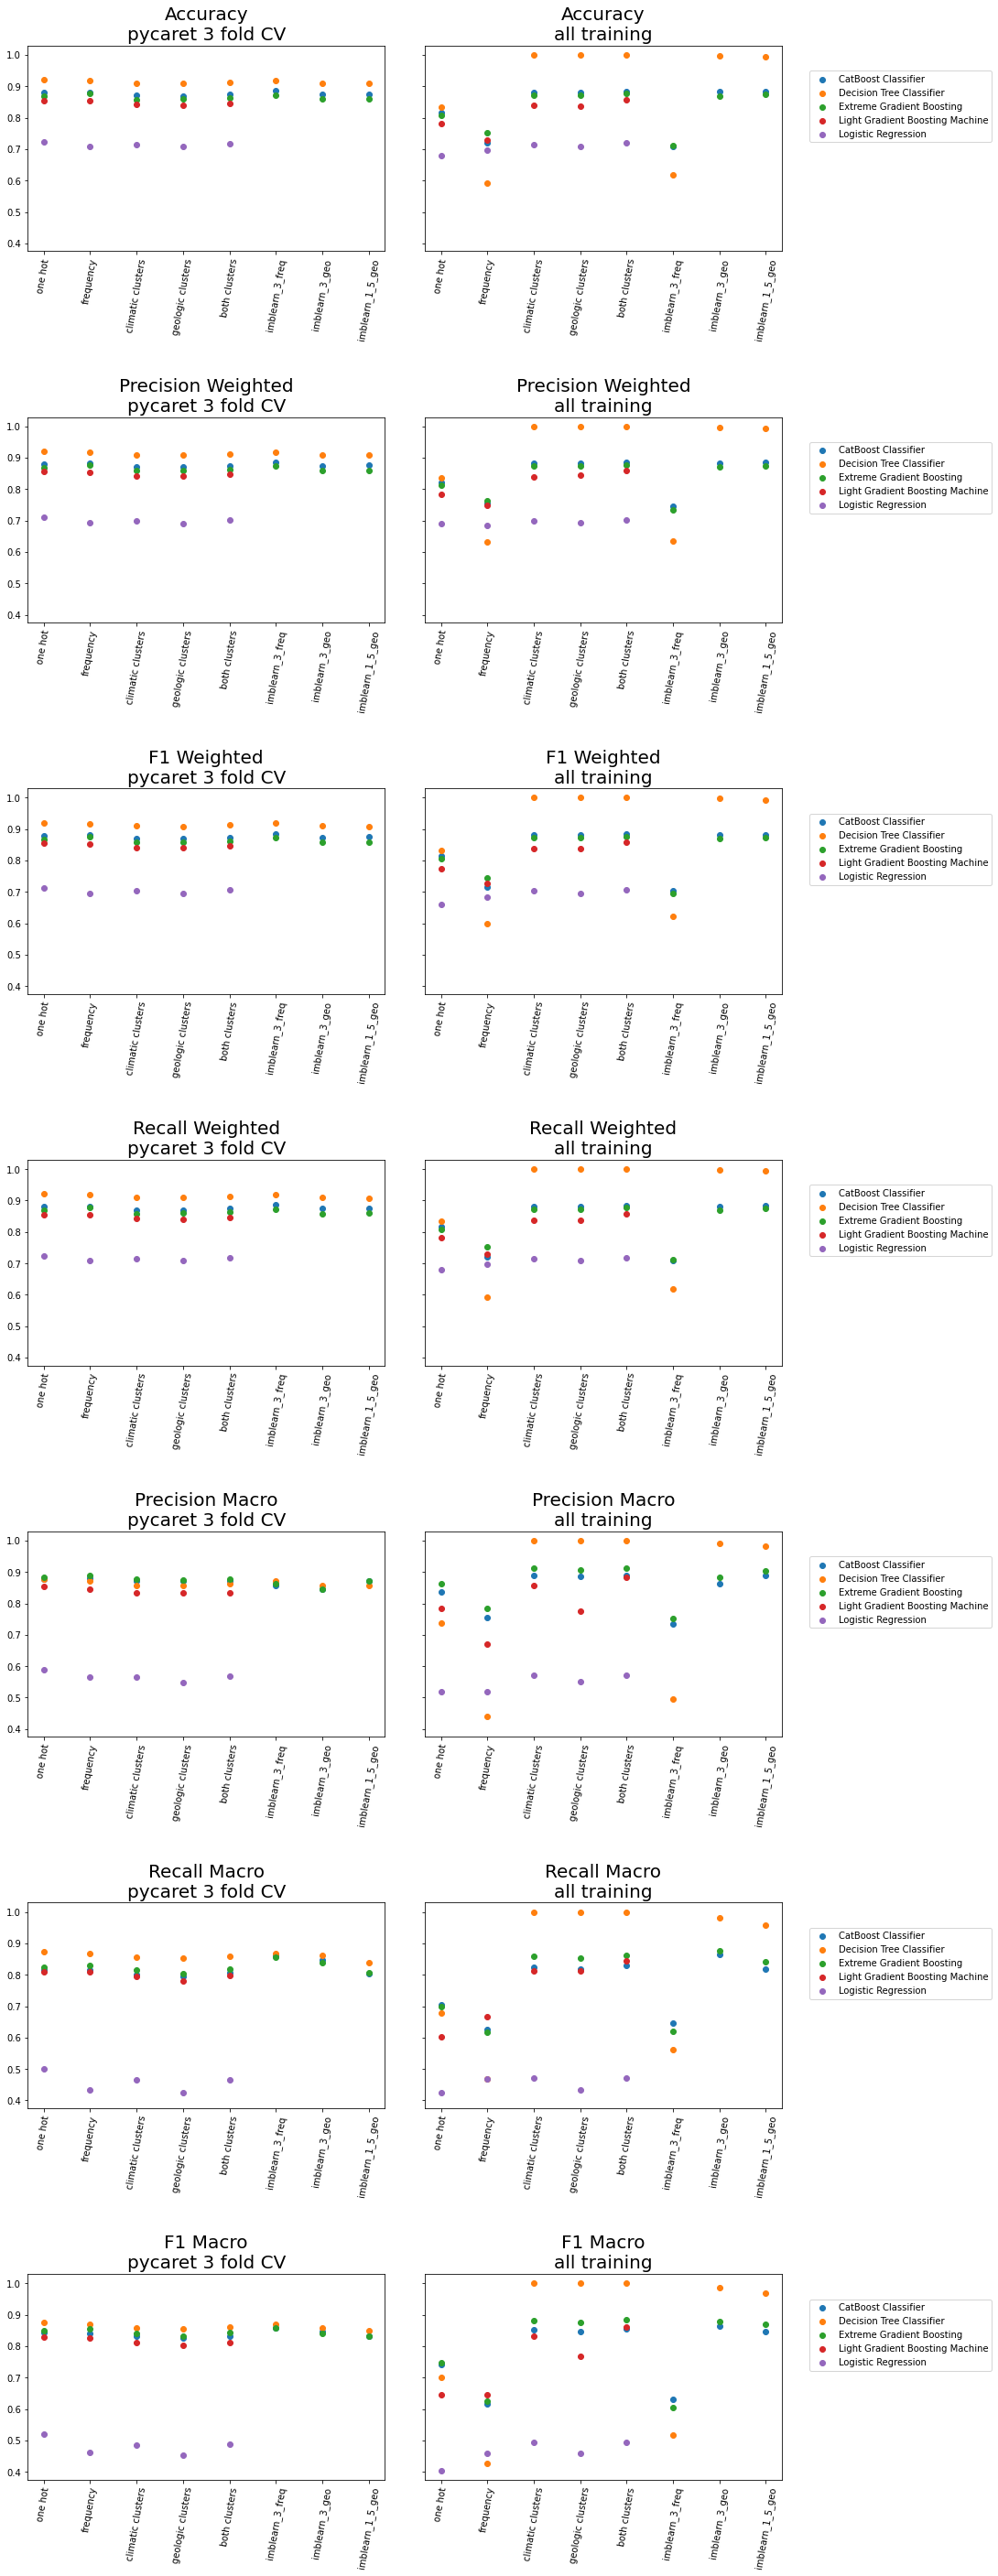

In [29]:
# NEW PLOTS

all_metrics = list(df_pycaret_results.columns.drop(['Model', 'soil encoding', 'imblearn', 'Train Time, sec']))

fig, ax = plt.subplots(len(all_metrics), 2, sharey=True)
fig.set_figheight(40)
fig.set_figwidth(16)
fig.set_tight_layout({'pad':4})

iplot = 0

for metric in all_metrics:
#for metric in ['Accuracy']:
    df_temp_0 = df_pycaret_results[['Model', 'soil encoding', metric]]
    df_temp_1 = df_results_summary[['Model', 'soil encoding', metric]]
    #_ = plt.figure()
    
    for group, subset in df_temp_0.groupby('Model'):
        _ = ax[iplot][0].scatter(x=subset['soil encoding'], y=subset[metric], label=group)
        #_ = ax[iplot][0].legend(bbox_to_anchor=(1.6, 0.9), loc='upper right')
        _ = ax[iplot][0].xaxis.set_tick_params(rotation=80)
        _ = ax[iplot][0].set_title(metric+'\npycaret 3 fold CV', size=20, weight=50)
    
    for group, subset in df_temp_1.groupby('Model'):
        _ = ax[iplot][1].scatter(x=subset['soil encoding'], y=subset[metric], label=group)
        _ = ax[iplot][1].legend(bbox_to_anchor=(1.6, 0.9), loc='upper right')
        _ = ax[iplot][1].xaxis.set_tick_params(rotation=80)
        _ = ax[iplot][1].set_title(metric+'\nall training', size=20, weight=50)
    
    iplot += 1
    #_ = plt.show()

#_ = fig.suptitle('performance metric by model', size=30, weight=100)

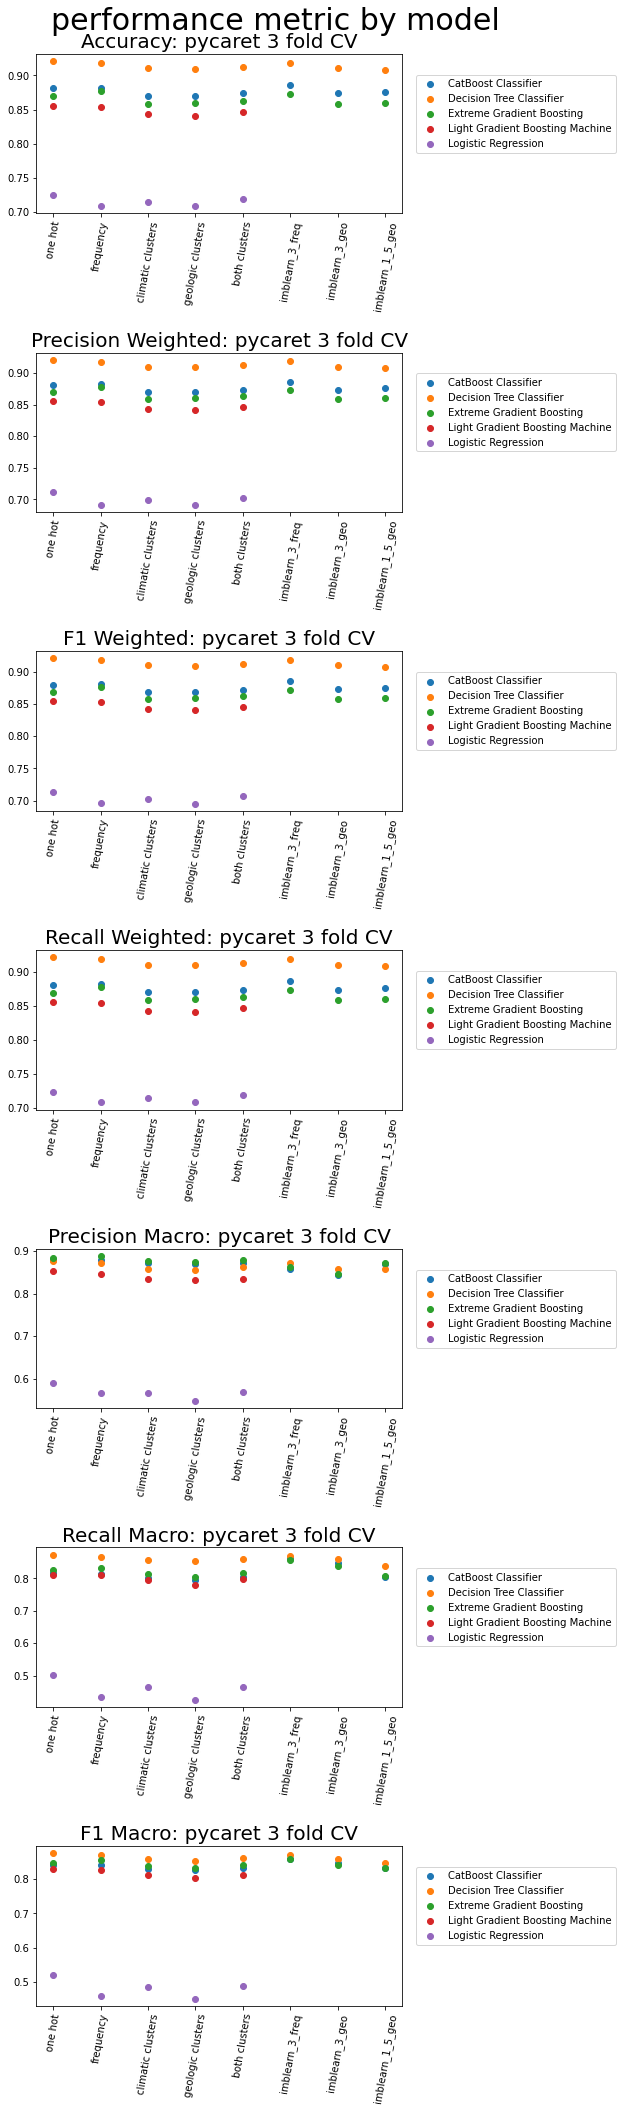

In [30]:
# ORIGINAL PLOTS

all_metrics = list(df_pycaret_results.columns.drop(['Model', 'soil encoding', 'imblearn', 'Train Time, sec']))

fig, ax = plt.subplots(len(all_metrics), 1)
fig.set_figheight(30)
fig.set_figwidth(8)
fig.set_tight_layout({'pad':2})

iplot = 0

for metric in all_metrics:
    df_temp = df_pycaret_results[['Model', 'soil encoding', metric]]
    #_ = plt.figure()
    
    for group, subset in df_temp.groupby('Model'):
        _ = ax[iplot].scatter(x=subset['soil encoding'], y=subset[metric], label=group)
        _ = ax[iplot].legend(bbox_to_anchor=(1.6, 0.9), loc='upper right')
        _ = ax[iplot].xaxis.set_tick_params(rotation=80)
        _ = ax[iplot].set_title(metric+': pycaret 3 fold CV', size=20, weight=50)
    
    iplot += 1
    #_ = plt.show()

_ = fig.suptitle('performance metric by model', size=30, weight=100)

# plots: train time

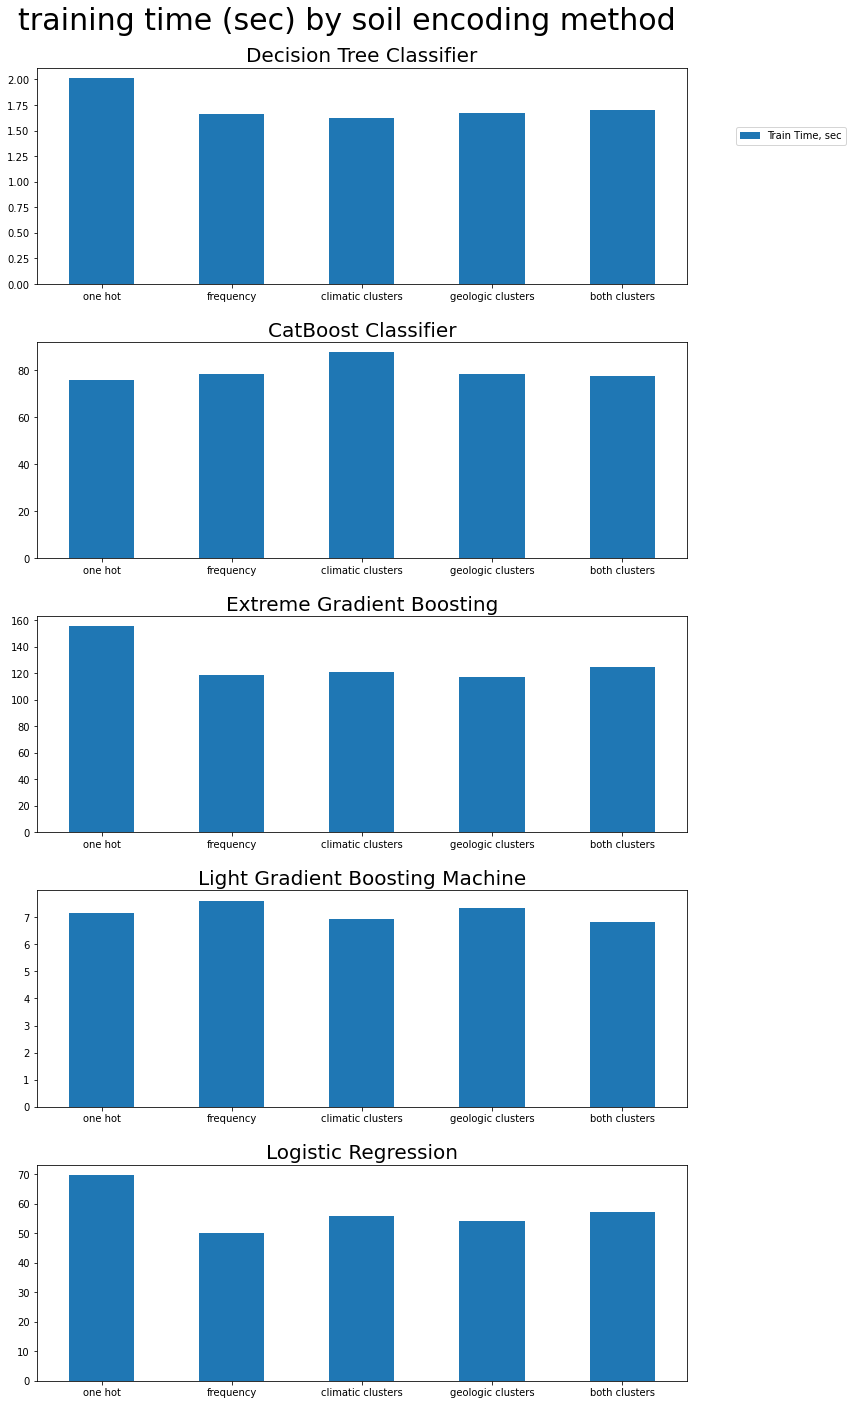

In [31]:
plot_soil_encoding_results(df_pycaret_results, plot_time=True)

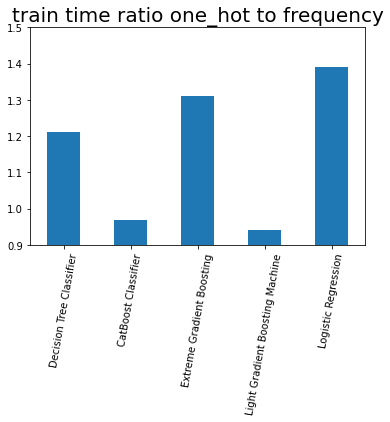

In [32]:
all_models = list(df_pycaret_results['Model'].unique())
list_model = []
list_ratio = []

for model in all_models:
    df_temp = df_pycaret_results[(df_pycaret_results['Model']==model) & (df_pycaret_results['imblearn']=='no')]
    #df_temp
    t1 = df_temp[df_temp['soil encoding']=='one hot']['Train Time, sec'].values[0]
    t2 = df_temp[df_temp['soil encoding']=='frequency']['Train Time, sec'].values[0]
    ratio = t1 / t2
    #ratio
    
    list_model.append(model)
    list_ratio.append(ratio)

df_time_ratio = pd.DataFrame({'model':list_model , 'ratio':list_ratio})
#df_time_ratio

ax = df_time_ratio.set_index('model').plot.bar(legend=False)
_ = ax.set_xlabel('')
_ = ax.xaxis.set_tick_params(rotation=80)
_ = ax.set_ybound(lower=0.9, upper=1.5)
_ = ax.set_title('train time ratio one_hot to frequency', size=20, weight=50)

# plots: performance by class
### predict training set with `pycaret` fitted models (same data as above plots of macro and weighted metrics)

In [33]:
df_results_by_class.head()

,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen


In [34]:
df_target_counts_sort = df_target_counts.sort_values('count', ascending=False).set_index('target_name')
df_target_counts_sort

,cover_type,count,fraction
target_name,,,
lodgepole_pine,2,283301,0.487599
spruce_fir,1,211840,0.364605
ponderosa_pine,3,35754,0.061537
krummholz,7,20510,0.035300
douglas_fir,6,17367,0.029891
aspen,5,9493,0.016339
cottonwood_willow,4,2747,0.004728


In [35]:
df_target_counts_sort.index.to_list()

['lodgepole_pine',
 'spruce_fir',
 'ponderosa_pine',
 'krummholz',
 'douglas_fir',
 'aspen',
 'cottonwood_willow']

In [36]:
df_target_counts_sort.loc['aspen']['fraction']

0.016338733107061472

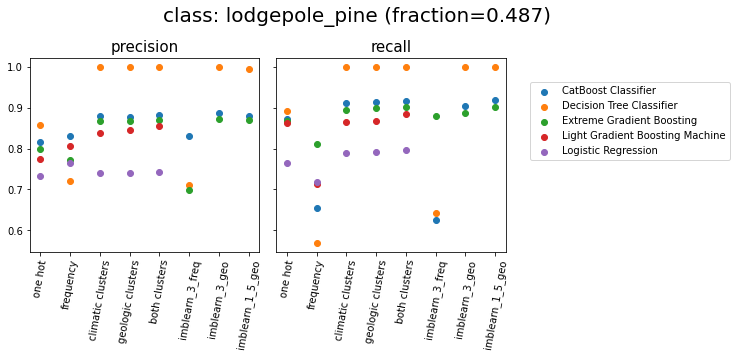

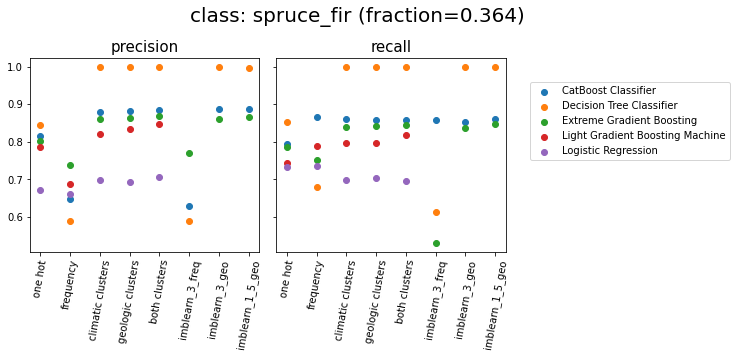

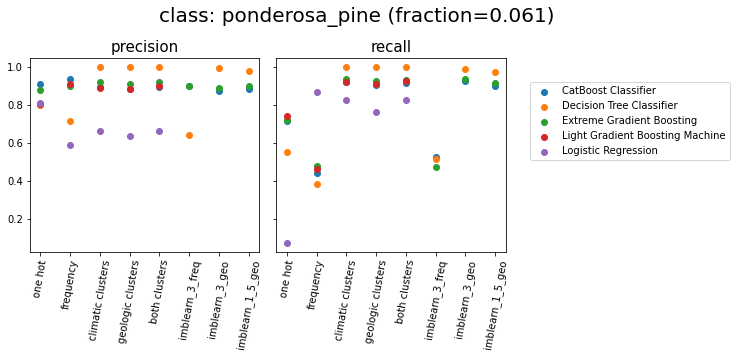

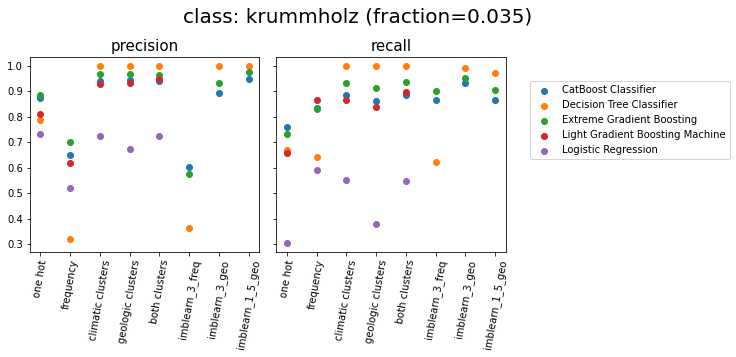

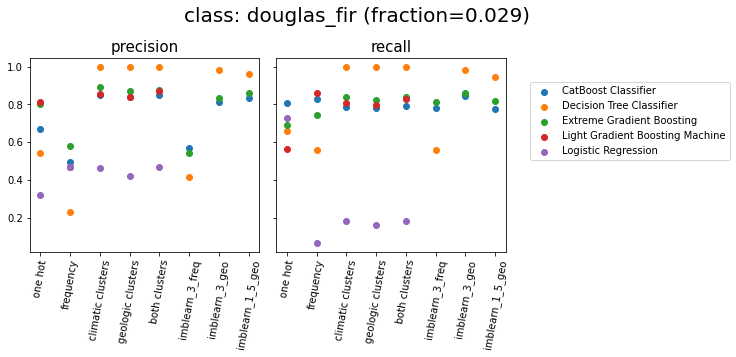

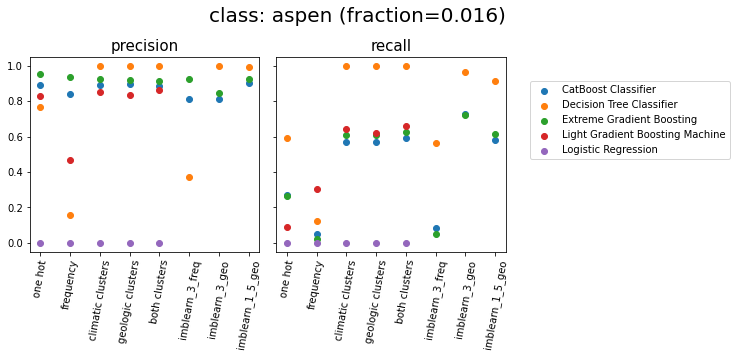

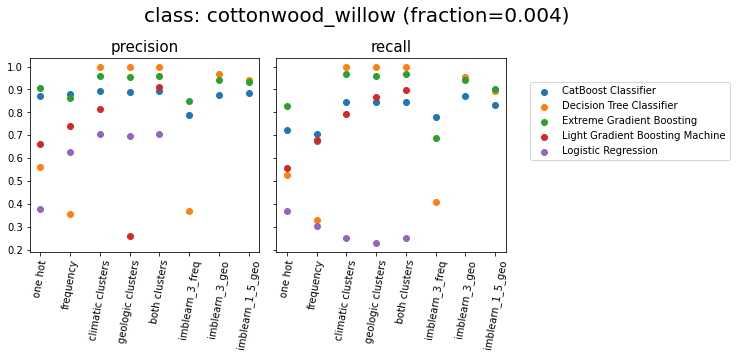

In [37]:
for the_class in df_target_counts_sort.index.to_list():
    fraction_class = df_target_counts_sort.loc[the_class]['fraction']
    df_one_class = df_results_by_class[df_results_by_class['class']==the_class][['model', 'soil encoding', 'precision', 'recall']]
    #df_one_class

    fig, ax = plt.subplots(1, 2, sharey=True)
    _ = fig.set_figheight(5)
    _ = fig.set_figwidth(10)
    _ = fig.suptitle('class: ' + the_class + ' (fraction=' + str(fraction_class)[:5] + ')', size=20, weight=100)
    _ = fig.set_tight_layout({'pad':1})

    for group, subset in df_one_class.groupby('model'):
        _ = ax[0].scatter(x=subset['soil encoding'], y=subset['precision'], label=group)
        _ = ax[0].xaxis.set_tick_params(rotation=80)
        #_ = ax[0].legend()
        _ = ax[0].set_title('precision', size=15, weight=50)

        _ = ax[1].scatter(x=subset['soil encoding'], y=subset['recall'], label=group)
        _ = ax[1].xaxis.set_tick_params(rotation=80)
        _ = ax[1].legend(bbox_to_anchor=(2.0, 0.9), loc='upper right')
        _ = ax[1].set_title('recall', size=15, weight=50)

# impact of `imblearn`

In [38]:
cols_to_keep = ['model', 'precision', 'recall', 'f1-score', 'class']

In [39]:
df_yes_3 = df_results_by_class[(    (df_results_by_class['soil encoding']=='imblearn_3_geo') &
                                 (  (df_results_by_class['model']=='Extreme Gradient Boosting') |
                                    (df_results_by_class['model']=='CatBoost Classifier')
                                 )
                               )][cols_to_keep]

df_yes_3 = df_yes_3.rename(columns=
                       {'precision':'precision_3',
                        'recall':'recall_3',
                        'f1-score':'f1_3'
                       })

df_yes_3

df_yes_1_5 = df_results_by_class[(    (df_results_by_class['soil encoding']=='imblearn_1_5_geo') &
                                   (  (df_results_by_class['model']=='Extreme Gradient Boosting') |
                                      (df_results_by_class['model']=='CatBoost Classifier')
                                   )
                                 )][cols_to_keep]

df_yes_1_5 = df_yes_1_5.rename(columns=
                       {'precision':'precision_1_5',
                        'recall':'recall_1_5',
                        'f1-score':'f1_1_5'
                       })

df_yes_1_5

df_yes = pd.merge(df_yes_3, df_yes_1_5, how='left', left_on=['model', 'class'], right_on=['model', 'class'])
df_yes

,model,precision_3,recall_3,f1_3,class
196,Extreme Gradient Boosting,0.860779,0.836518,0.848475,spruce_fir
197,Extreme Gradient Boosting,0.872261,0.886153,0.879152,lodgepole_pine
198,Extreme Gradient Boosting,0.886500,0.934669,0.909948,ponderosa_pine
199,Extreme Gradient Boosting,0.941636,0.940166,0.940901,cottonwood_willow
200,Extreme Gradient Boosting,0.846397,0.722581,0.779603,aspen
201,Extreme Gradient Boosting,0.835721,0.861148,0.848244,douglas_fir
202,Extreme Gradient Boosting,0.931685,0.949986,0.940746,krummholz
210,CatBoost Classifier,0.887013,0.851461,0.868874,spruce_fir
211,CatBoost Classifier,0.886075,0.904258,0.895074,lodgepole_pine
212,CatBoost Classifier,0.870257,0.925587,0.897070,ponderosa_pine


,model,precision_1_5,recall_1_5,f1_1_5,class
217,Extreme Gradient Boosting,0.865849,0.847498,0.856576,spruce_fir
218,Extreme Gradient Boosting,0.870783,0.900513,0.885399,lodgepole_pine
219,Extreme Gradient Boosting,0.900322,0.912481,0.906361,ponderosa_pine
220,Extreme Gradient Boosting,0.932149,0.900624,0.916115,cottonwood_willow
221,Extreme Gradient Boosting,0.924383,0.612603,0.736871,aspen
222,Extreme Gradient Boosting,0.860066,0.817942,0.838475,douglas_fir
223,Extreme Gradient Boosting,0.974769,0.904221,0.938171,krummholz
231,CatBoost Classifier,0.886703,0.861688,0.874017,spruce_fir
232,CatBoost Classifier,0.880407,0.917638,0.898637,lodgepole_pine
233,CatBoost Classifier,0.881977,0.896945,0.889398,ponderosa_pine


,model,precision_3,recall_3,f1_3,class,precision_1_5,recall_1_5,f1_1_5
0,Extreme Gradient Boosting,0.860779,0.836518,0.848475,spruce_fir,0.865849,0.847498,0.856576
1,Extreme Gradient Boosting,0.872261,0.886153,0.879152,lodgepole_pine,0.870783,0.900513,0.885399
2,Extreme Gradient Boosting,0.886500,0.934669,0.909948,ponderosa_pine,0.900322,0.912481,0.906361
3,Extreme Gradient Boosting,0.941636,0.940166,0.940901,cottonwood_willow,0.932149,0.900624,0.916115
4,Extreme Gradient Boosting,0.846397,0.722581,0.779603,aspen,0.924383,0.612603,0.736871
5,Extreme Gradient Boosting,0.835721,0.861148,0.848244,douglas_fir,0.860066,0.817942,0.838475
6,Extreme Gradient Boosting,0.931685,0.949986,0.940746,krummholz,0.974769,0.904221,0.938171
7,CatBoost Classifier,0.887013,0.851461,0.868874,spruce_fir,0.886703,0.861688,0.874017
8,CatBoost Classifier,0.886075,0.904258,0.895074,lodgepole_pine,0.880407,0.917638,0.898637
9,CatBoost Classifier,0.870257,0.925587,0.897070,ponderosa_pine,0.881977,0.896945,0.889398


In [40]:
df_no = df_results_by_class[(     (df_results_by_class['soil encoding']=='geologic clusters') &
                               (  (df_results_by_class['model']=='Extreme Gradient Boosting') |
                                  (df_results_by_class['model']=='CatBoost Classifier')
                               )
                             )][cols_to_keep]

df_no = df_no.rename(columns=
                       {'precision':'precision_no',
                        'recall':'recall_no',
                        'f1-score':'f1_no'
                       })
df_no

,model,precision_no,recall_no,f1_no,class
112,CatBoost Classifier,0.882638,0.858082,0.870187,spruce_fir
113,CatBoost Classifier,0.878190,0.914333,0.895897,lodgepole_pine
114,CatBoost Classifier,0.881791,0.903956,0.892736,ponderosa_pine
115,CatBoost Classifier,0.887193,0.847034,0.866649,cottonwood_willow
116,CatBoost Classifier,0.894861,0.566992,0.694159,aspen
117,CatBoost Classifier,0.839438,0.778529,0.807837,douglas_fir
118,CatBoost Classifier,0.942624,0.861730,0.900364,krummholz
119,Extreme Gradient Boosting,0.862703,0.842701,0.852585,spruce_fir
120,Extreme Gradient Boosting,0.868406,0.897876,0.882895,lodgepole_pine
121,Extreme Gradient Boosting,0.906161,0.923993,0.914990,ponderosa_pine


In [41]:
df_compare = pd.merge(df_yes, df_no, how='left', left_on=['model', 'class'], right_on=['model', 'class'])

df_compare['precision_dif_3'] = df_compare['precision_3'] - df_compare['precision_no']
df_compare['recall_dif_3']    = df_compare['recall_3']    - df_compare['recall_no']
df_compare['f1_dif_3']        = df_compare['f1_3']        - df_compare['f1_no']

df_compare['precision_dif_1_5'] = df_compare['precision_1_5'] - df_compare['precision_no']
df_compare['recall_dif_1_5']    = df_compare['recall_1_5']    - df_compare['recall_no']
df_compare['f1_dif_1_5']        = df_compare['f1_1_5']        - df_compare['f1_no']

df_compare['fraction'] = df_compare['class'].apply(get_target_fraction_from_name)
df_compare = df_compare.sort_values(['model', 'fraction'], ascending=[True, True])

df_compare

,model,precision_3,recall_3,f1_3,class,precision_1_5,recall_1_5,f1_1_5,precision_no,recall_no,f1_no,precision_dif_3,recall_dif_3,f1_dif_3,precision_dif_1_5,recall_dif_1_5,f1_dif_1_5,fraction
10,CatBoost Classifier,0.877615,0.873049,0.875326,cottonwood_willow,0.884042,0.832986,0.857755,0.887193,0.847034,0.866649,-0.009578,0.026015,0.008677,-0.003151,-0.014048,-0.008894,0.004728
11,CatBoost Classifier,0.811567,0.726332,0.766587,aspen,0.900210,0.579295,0.704948,0.894861,0.566992,0.694159,-0.083294,0.159340,0.072429,0.005348,0.012303,0.010789,0.016339
12,CatBoost Classifier,0.814738,0.844162,0.829189,douglas_fir,0.834527,0.778034,0.805291,0.839438,0.778529,0.807837,-0.024700,0.065633,0.021352,-0.004911,-0.000495,-0.002546,0.029891
13,CatBoost Classifier,0.894494,0.930134,0.911966,krummholz,0.948936,0.863402,0.904151,0.942624,0.861730,0.900364,-0.048131,0.068403,0.011602,0.006312,0.001672,0.003787,0.035300
9,CatBoost Classifier,0.870257,0.925587,0.897070,ponderosa_pine,0.881977,0.896945,0.889398,0.881791,0.903956,0.892736,-0.011533,0.021631,0.004334,0.000187,-0.007011,-0.003338,0.061537
7,CatBoost Classifier,0.887013,0.851461,0.868874,spruce_fir,0.886703,0.861688,0.874017,0.882638,0.858082,0.870187,0.004375,-0.006621,-0.001313,0.004065,0.003606,0.003830,0.364605
8,CatBoost Classifier,0.886075,0.904258,0.895074,lodgepole_pine,0.880407,0.917638,0.898637,0.878190,0.914333,0.895897,0.007885,-0.010075,-0.000823,0.002217,0.003305,0.002740,0.487599
3,Extreme Gradient Boosting,0.941636,0.940166,0.940901,cottonwood_willow,0.932149,0.900624,0.916115,0.952996,0.959938,0.956454,-0.011360,-0.019771,-0.015553,-0.020847,-0.059313,-0.040339,0.004728
4,Extreme Gradient Boosting,0.846397,0.722581,0.779603,aspen,0.924383,0.612603,0.736871,0.921511,0.611253,0.734981,-0.075114,0.111328,0.044622,0.002872,0.001350,0.001890,0.016339
5,Extreme Gradient Boosting,0.835721,0.861148,0.848244,douglas_fir,0.860066,0.817942,0.838475,0.871721,0.821982,0.846121,-0.036000,0.039166,0.002122,-0.011655,-0.004040,-0.007646,0.029891


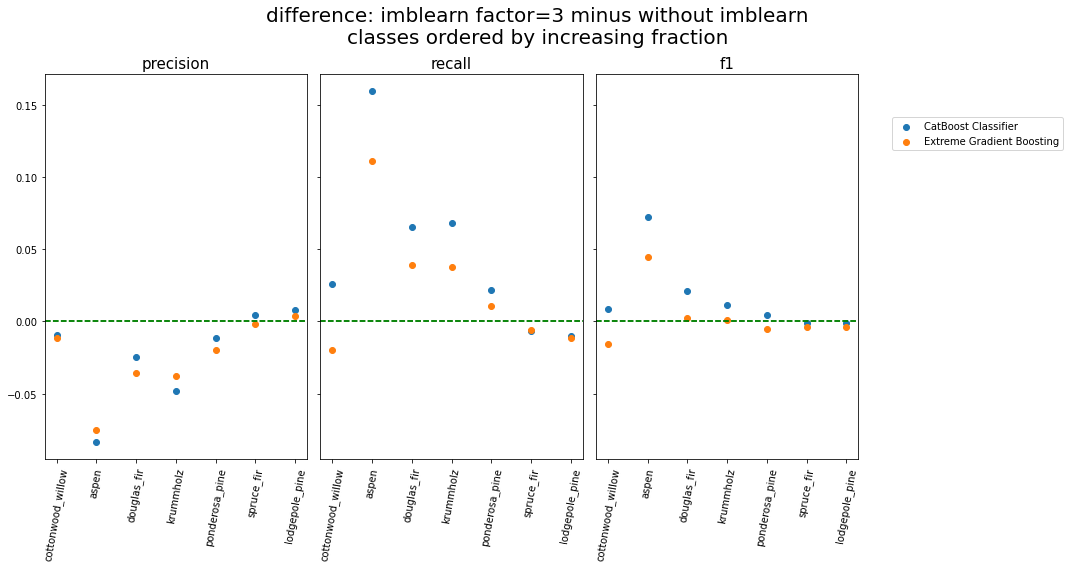

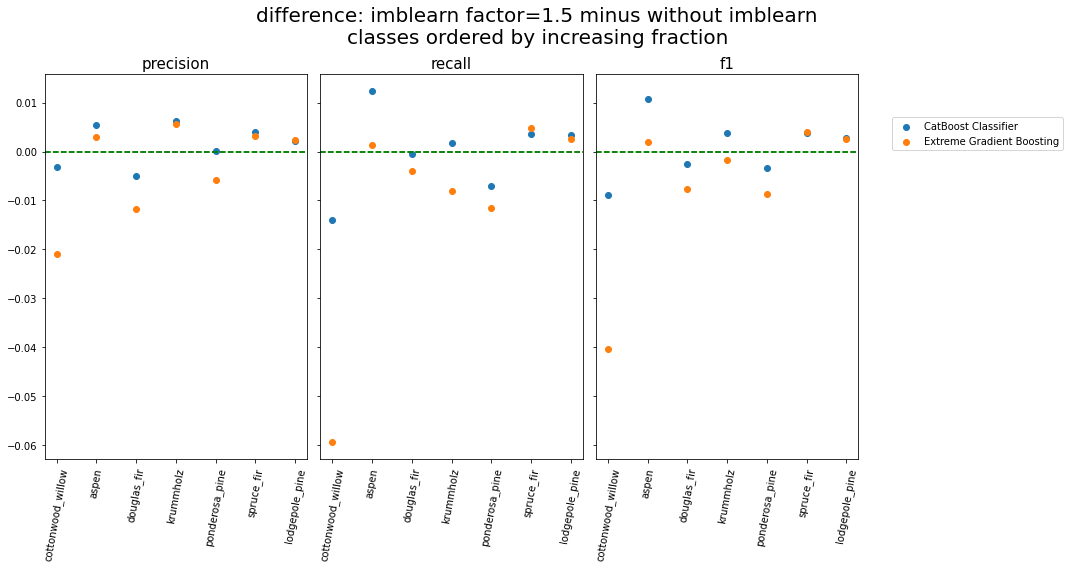

In [42]:
factor = ['3' , '1.5']
suffix = ['_3' , '_1_5']

for index in range (2):
    fig, ax = plt.subplots(1, 3, sharey=True)
    _ = fig.set_figheight(8)
    _ = fig.set_figwidth(15)
    _ = fig.suptitle('difference: imblearn factor=' + factor[index] + ' minus without imblearn\nclasses ordered by increasing fraction',
                     size=20, weight=100)
    _ = fig.set_tight_layout({'pad':1})

    for group, subset in df_compare.groupby('model'):
        _ = ax[0].scatter(x=subset['class'], y=subset['precision_dif'+suffix[index]], label=group)
        _ = ax[0].xaxis.set_tick_params(rotation=80)
        #_ = ax[0].legend(bbox_to_anchor=(2.0, 0.9), loc='upper right')
        _ = ax[0].set_title('precision', size=15, weight=50)
        _ = ax[0].axhline(y=0, color='green', linestyle="--")

        _ = ax[1].scatter(x=subset['class'], y=subset['recall_dif'+suffix[index]], label=group)
        _ = ax[1].xaxis.set_tick_params(rotation=80)
        #_ = ax[1].legend(bbox_to_anchor=(2.0, 0.9), loc='upper right')
        _ = ax[1].set_title('recall', size=15, weight=50)
        _ = ax[1].axhline(y=0, color='green', linestyle="--")

        _ = ax[2].scatter(x=subset['class'], y=subset['f1_dif'+suffix[index]], label=group)
        _ = ax[2].xaxis.set_tick_params(rotation=80)
        _ = ax[2].legend(bbox_to_anchor=(1.8, 0.9), loc='upper right')
        _ = ax[2].set_title('f1', size=15, weight=50)
        _ = ax[2].axhline(y=0, color='green', linestyle="--")

# write pickle

In [43]:
#df_soil_encoding_results.to_pickle('data/soil_encoding_pycaret_results_large.pkl')